# Poisson Disk Sampling


This module is an implementation of the active mini-batch sampling scheme proposed by [[1]](https://arxiv.org/pdf/1804.02772.pdf). Repuslive point processes are a formalism to sample a susbet of points that Zhang *et al.* show can reduce the variance of stochastic gradient estimates. Poisson disk sampling is one such repulsive point process that has a small overhead compared to similar schemes such as determinantal point processes [[2]](https://arxiv.org/abs/1705.00607).


[[1]](https://arxiv.org/abs/1804.02772) C. Zhang *et al.*, Active Mini-Batch Samplingusing Repulsive Point Processes, arXiv:1804.02772, (2018).

[[2]](https://arxiv.org/abs/1705.00607) C. Zhang *et al.*, Determinantal Point Processes for Mini-Batch Diversification, arXiv:1705.00607, (2017)

In [1]:
from sampling.pds import PoissonDiskSampling
import matplotlib.pyplot as plt
import numpy as np
import itertools
import tensorflow as tf
from pydoc import locate

### Toy problem

Let's imagine a toy classifier $\mathbb{R}^2\rightarrow\mathbb{Z}$ that assigns a class label $y$ by:

\begin{equation}
y = \begin{cases}
0 &, x^2 > \sin(x^1) \\
1 &, \mathrm{otherwise}
\end{cases}
\end{equation},

where $\mathbf{x}=(x^1,x^2)\in\mathbb{R}^2$.

In [2]:
true_classifier = lambda _x : 0 if _x[1]>np.sin(_x[0]) else 1

Generate a set of training examples with a bias away from the decision boundary.

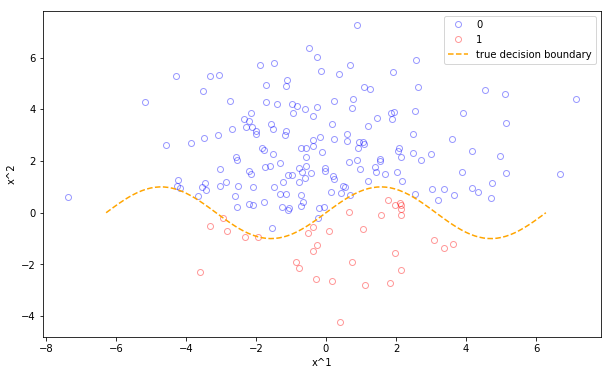

In [3]:
# generate toy data
X = np.random.multivariate_normal(mean=[0,2],cov=[[2*np.pi,0],[0,np.pi]],size=200)

# true labels
y = np.asarray([true_classifier(_x) for _x in X])

def plot_train_data(X,y,_ax):
    _ax.plot(X[np.where(y==0)[0]][:,0],X[np.where(y==0)[0]][:,1],\
             marker="o",color="blue",linestyle="none",label="0",\
             markerfacecolor="none",alpha=0.4)
    _ax.plot(X[np.where(y==1)[0]][:,0],X[np.where(y==1)[0]][:,1],\
            marker="o",markerfacecolor="none",linestyle="none",\
            color="red",label="1",alpha=0.4)

    _ax.plot(np.linspace(-np.pi*2,np.pi*2,100),\
            np.sin(np.linspace(-np.pi*2,np.pi*2,100)),color="orange",\
            linestyle="--",label="true decision boundary")
    
    _ax.set_xlabel("x^1")
    _ax.set_ylabel("x^2")
    _ax.legend()


fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(10,6))    
    
    
plot_train_data(X,y,ax)    
plt.show()

Figure 1: The observed labelled data are distributed off-center from the decision boundary.

### Inference

Let's infer the decision boundary using stochastic gradient descent of the minimum cross entropy estimate for a fully-connected feed forward neural network.

In [4]:
class MLPClassifier():
    def __init__(self,number_nodes=[5,5],maxiter=10,Nsample=20,initial_learning_rate=1e-3,decay_learning_rate=1e-1):
        # dimension of input
        self.dimX = 2
        
        # number of categories
        self.dimY = 2
        
        # nodes per layer
        self.number_nodes = number_nodes
        
        # non-linear function to apply to all but final output layer
        self.activation_type = "sigmoid"
        
        # number of samples in mini-batch
        self.Nsample = Nsample
        
        # learning rate for SGD
        self.lr = initial_learning_rate
        
        # pre-factor for learning rate
        self.init_learning_rate = initial_learning_rate
        
        # exponential decay factor for learning rate
        self.decay_learning_rate = decay_learning_rate
        
        # number of mini-batch iterations
        self.maxiter = maxiter
        
        # define conditional dependencies
        self._init_graph()
        
    def _init_graph(self):
        # nodes per layer including input and output
        nodes = [self.dimX]+list(self.number_nodes)+[self.dimY]
                        
        with tf.variable_scope("observed_variables"):
            # unknown mini-batch size
            self.X = tf.placeholder(tf.float64,[None,self.dimX],name="X")
            self.T = tf.placeholder(tf.float64,[None,self.dimY],name="T")
        
        with tf.variable_scope("latent_variables"):
            # list of weights for each successive layer in MLP
            self.weights = [tf.Variable(tf.random.normal(shape=(nodes[ii],nodes[ii+1]),dtype=tf.float64),\
                    name="w{}".format(ii)) for ii in range(len(self.number_nodes)+1)]

            # biases
            self.biases = [tf.Variable(tf.zeros(shape=(nodes[ii+1]),dtype=tf.float64),name="b{}".format(ii)) \
                    for ii in range(len(self.number_nodes)+1)]
         
        # [None,self.dimY] array of category probabilities
        self._construct_model()

        # objective to minimize stochastically wrt latent parameters in net
        self._construct_loss()
        
        # start tf session
        self.session = tf.Session()
        
        # create instances of variables
        self.session.run(tf.global_variables_initializer())
        
                
    def _construct_model(self):
        # activation function for intermediate layers
        act1 = {"sigmoid":tf.math.sigmoid,"tanh":tf.math.tanh}[self.activation_type]
        
        # final layer
        idx = len(self.weights)-1
        
        # non-linear operation on output layer ii
        act_func = lambda _x,ii : act1(_x) if ii!=idx else tf.math.softmax(_x)
        
        
        layer_output = act_func(tf.add(tf.matmul(self.X,self.weights[0]),self.biases[0]),0)
        for ii in range(1,len(self.weights)):
            layer_output = act_func(tf.add(tf.matmul(layer_output,self.weights[ii]),self.biases[ii]),ii)   
        self.y = layer_output
     
        
    def _construct_loss(self):
        # use cross entropy
        self._loss = tf.reduce_mean(-tf.reduce_sum(self.T * tf.log(self.y), reduction_indices=[1]))
   
        # SGD optimizer
        self.optimizer = tf.train.GradientDescentOptimizer(learning_rate=self.lr)
        
        # apply stochastic gradients to minimize objective
        self.trainop = self.optimizer.apply_gradients(zip(tf.gradients(self._loss,\
                tf.trainable_variables()),tf.trainable_variables()))
      
        
    def fit(self,X,y,minibatch_sampler):
        if not isinstance(minibatch_sampler,PoissonDiskSampling): raise Exception("Expecting a PDS instance.")
        
        
        writer = tf.summary.FileWriter('./graphs', self.session.graph)
             
        self.loss = np.zeros(self.maxiter)
        
        for ii in range(self.maxiter):           
            Xsample,ysample = minibatch_sampler.sample(self.Nsample)
            
            feed = {self.X:Xsample,self.T:self._reformatY(ysample)}
            
            _,loss = self.session.run([self.trainop,self._loss], feed)
            
            # book keeping
            self.loss[ii] = loss
            self.iter = ii
            
            # update learning rate
            self._update_learning_rate()
   
    def predict(self,X):
        # [N,self.dimY] probabilities
        [res] = self.session.run([self.y],{self.X:X})

        # label highest probable category
        res = np.asarray([np.argmax(_y) for _y in res],dtype=np.int)
        
        return res

    def _update_learning_rate(self):
        # exponential decay
        self.lr = self.init_learning_rate*np.exp(-self.iter*self.decay_learning_rate)
    
    def _reformatY(self,y):
        # parse a [N,] array of categorical data into a [N,self.dimY] array of binary values
        
        Y = np.zeros((y.shape[0],self.dimY))

        
        for ii in range(y.shape[0]):
            Y[ii,y[ii]] = 1
            
        return Y  

### Sampling variations

Zhang *et al.* [[1]](https://arxiv.org/abs/1804.02772) cover a number of variations in the mini-batch diversification via Poisson disk sampling.

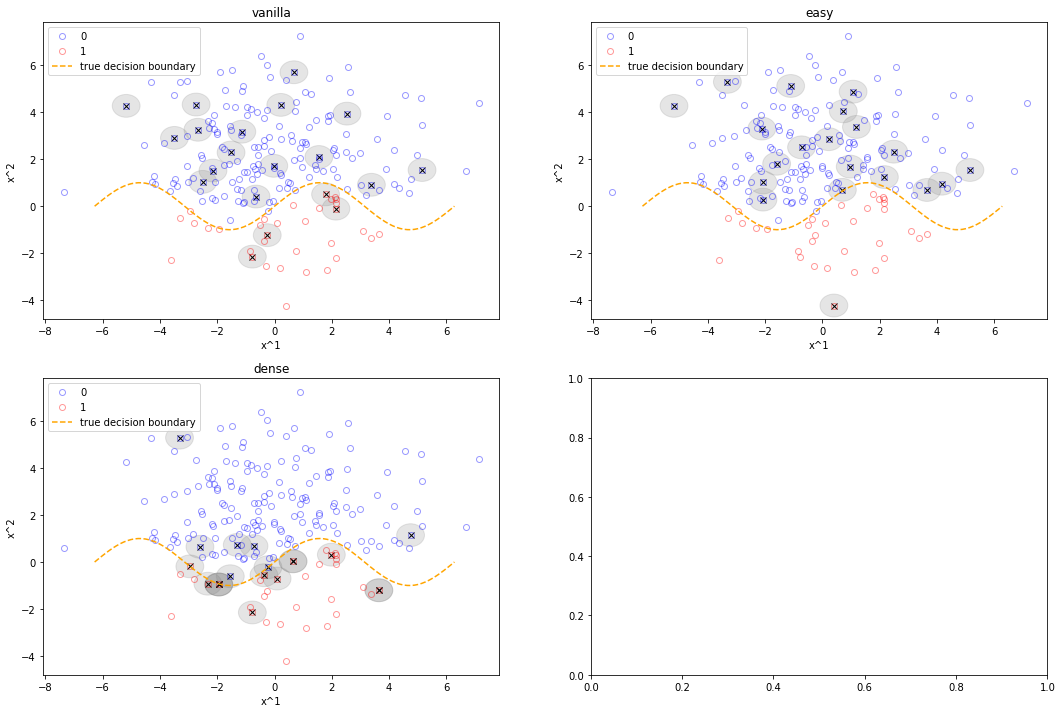

In [5]:
samplers = {_k:PoissonDiskSampling(X,y,_k) for _k in ["vanilla","easy","dense"]}
samples = {_k:samplers[_k].sample(20) for _k in samplers.keys()}
keys = list(samplers.keys())


fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(18,12))

for ii,[rr,cc] in enumerate(itertools.product(range(2),range(2))):
    if ii==3:
        break
    # sampled points
    axes[rr][cc].plot(samples[keys[ii]][0][:,0],samples[keys[ii]][0][:,1],marker="x",linestyle="none",\
            color="black")

    # show complete train set
    plot_train_data(X,y,axes[rr][cc])

    # show exclusion zones
    _ = [axes[rr][cc].add_artist(plt.Circle(_x, samplers[keys[ii]].r, color='grey',alpha=0.2)) \
            for _x in samples[keys[ii]][0]]
    
    axes[rr][cc].set_title(keys[ii])

#ax.set_aspect("equal")
plt.show()

Lets calculate a minimum cross-entropy estimate 

\begin{equation}
L(\mathbf{z}) = -\sum_{i} p(t_i) \ln p(y_i | \mathbf{x}_i,\mathbf{z}),
\end{equation}
where $p(t_i)$ are Dirac delta functions centred on observed labels $t_i$ and $p(y_i | \mathbf{x}_i,\mathbf{z})$ is the amortized categorical distribution resulting from a fully-connected feed-forward neural network with latent variables $\mathbf{z}$.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


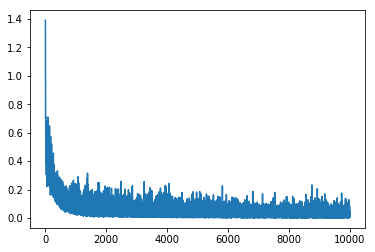

In [6]:
model = MLPClassifier(maxiter=10000,initial_learning_rate=1e-1,decay_learning_rate=1e-3)
model.fit(X,y,PoissonDiskSampling(X,y,method="easy"))

plt.plot(np.arange(len(model.loss)),model.loss)
plt.show()

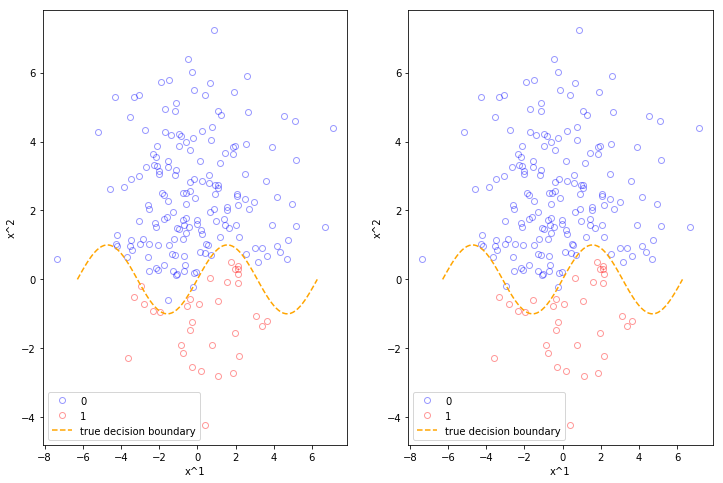

In [12]:
ypred = model.predict(X)

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(12,8))


plot_train_data(X,y,axes[0])
plot_train_data(X,ypred,axes[1])
plt.show()

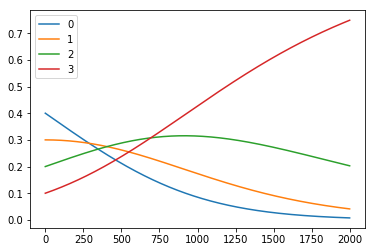

In [8]:
# annealing schedule

K = 4

coeffs = np.asarray([[(K-kk)*np.exp(-iter*(K-kk)/1000) for kk in range(K)] for iter in range(2000)])

# normalise
coeffs /= np.tile(np.sum(coeffs,axis=1),(coeffs.shape[1],1)).T

_ = [plt.plot(np.arange(coeffs.shape[0]),coeffs[:,ii],label="{}".format(ii)) for ii in range(K)]
plt.legend()
plt.show()